In [1]:
using LinearAlgebra
using Symbolics
using MultivariatePolynomials
using DynamicPolynomials
using HomotopyContinuation
using CairoMakie                 # para plots
using Distributions
using Random

# Função que arredonda polinômios

function roundp(p)
      if p isa AbstractPolynomialLike
          cs = coefficients(p)
          ms = monomials(p)
          return isempty(cs) ? zero(p) : sum(round(c; digits=1) * m for (c, m) in zip(cs, ms))
      elseif p isa Number
          return round(p; digits=2)
      elseif p isa AbstractArray
          return map(roundp, p)
      else
          error("Unsupported type in roundp: $(typeof(p))")
      end
  end
  # ---------

roundp (generic function with 1 method)

In [2]:
# Parâmetros:

n = 10^5 # 100 mil
k = 1
p = 1
q = p +1

m1 = q * q
m2 = k * q ;

In [3]:
gamma_0 = 2
b_0 = 3

Gamma_0 = [ 1 0 ;
            2 1  ]

B_0 = [0 3]

Σ =  [2 1;
      1 2]

Random.seed!(123)

U_0 = rand( MvNormal(zeros(q) , Σ  ) , n  )'
X = rand(n, k)


Y = X * B_0 * inv(Gamma_0) + U_0*inv(Gamma_0) ; 


In [4]:
# matrizes de restrição

R1 = [ ones(1, 1)                 zeros(1, p)                         zeros(1, p*q);
       zeros(p, 1)              zeros(p, p)                       zeros(p, p*q);
       zeros(p*q, 1)          zeros(p*q, p)                   Matrix( I, p*q, p*q )  ]

R2 = [ Matrix(I, k, k)                 zeros(k, k*p);
       zeros(k*p, k)               zeros(k*p, k*p)  ]


2×2 Matrix{Float64}:
 1.0  0.0
 0.0  0.0

In [5]:
# Gamma e b

@polyvar γ[1:p] b[1:k*p]

Γ = [ 1                    zeros(1, p);
      γ                    Matrix(I, p, p) ]


B = [ zeros(k, 1)   reshape(b, k, p) ]        

U = Y * Γ - X * B        # n×p (simbólico)

# multiplicadores

@polyvar   μ1[ 1: q^2 - p ]   μ2[1:k]

lambda1 = [ μ1[1] ; zeros(p,1) ; μ1[2:end]  ]   
lambda2 = [  μ2[1:k] ; zeros(k*p , 1) ]   

                          

2×1 Matrix{Term{Float64, DynamicPolynomials.Monomial{DynamicPolynomials.Commutative{DynamicPolynomials.CreationOrder}, Graded{LexOrder}}}}:
 μ2₁
 0.0

In [6]:
eqA = reshape(Y' * U, q*q, 1) +  kron(U' * U, Matrix(I, q, q)) * R1 * lambda1

eqB = reshape((X' * U)', k*q, 1) + kron(U' * U, Matrix(I, k, k)) * R2 * lambda2

# final

F = vec( [eqA ; eqB] ) 

vars = [ γ ; b ; μ1 ; μ2 ]


F_sys = System(F; variables=vars)


result = solve(F_sys ; start_system = :total_degree)

S_unr = [ real.(round.(sol; digits=4)) for sol in solutions(result)  ]


Tracking 729 paths... 100%|█████████████████████████████| Time: 0:00:08
                   # paths tracked: 729
   # non-singular solutions (real): 2 (2)
       # singular endpoints (real): 0 (0)
          # total solutions (real): 2 (2)


2-element Vector{Vector{Float64}}:
 [-0.0058, 0.0, -1.0, -0.0058, -1.0, 0.1109]
 [1.9977, 3.0122, -1.0, 1.9977, -1.0, 0.0]

In [7]:
m = 1

R3 = [ zeros(p,1)  Matrix(I, p , p)   zeros(p, p*q)  ]'
R4 = [  zeros(k*p,k)  Matrix(I, k*p , k*p)   ]'


g = [ b[1]^2 - γ[1]^2  - 2  ] 

∇γg = [  differentiate(g[j] , γ[i]) for i in 1:p , j in 1:m] 
∇bg = [  differentiate(g[j] , b[i]) for i in 1:p , j in 1:m] 

@polyvar y[1:m]  μ3[1:m]    #nesse caso, mu3 = lambda3, pois todas as derivadas parciais são não zero 

lambda3 = μ3
h = [ y[i]^2 for i in 1:m  ]'
f = [ lambda3[i]*y[i] for i in 1:m   ]

display( R3 * ∇γg) ;
display( R4 * ∇bg) ;



4×1 Matrix{DynamicPolynomials.Polynomial{DynamicPolynomials.Commutative{DynamicPolynomials.CreationOrder}, Graded{LexOrder}, Float64}}:
 0.0
 -2.0γ₁
 0.0
 0.0

2×1 Matrix{DynamicPolynomials.Polynomial{DynamicPolynomials.Commutative{DynamicPolynomials.CreationOrder}, Graded{LexOrder}, Float64}}:
 0.0
 2.0b₁

In [8]:
eqA = reshape(Y' * U, q*q, 1) +   kron(U' * U, Matrix(I, q, q)) * R1 * lambda1 + kron(U' * U, Matrix(I, q, q))*   R3 * ∇γg * lambda3

eqB = reshape((X' * U)', k*q, 1) + kron(U' * U, Matrix(I, k, k)) * R2 * lambda2 + kron(U' * U, Matrix(I, k, k))*  R4 * ∇bg * lambda3

eqC = g' + h

eqD = f

F = vec( [eqA ; eqB; eqC ; eqD] ) 

vars = [ γ ; b ; μ1 ; μ2 ; μ3 ; y  ]


F_sys = System(F; variables=vars) ; 

result = solve(F_sys ; start_system = :total_degree ) 

function G(x)
    return  x[2]^2 - x[1]^2 -2
end    

S = [ real.(sol) for sol in solutions(result) ] 

S_res = [ s for s in real(S) if G(s) <= 0];


Tracking 9216 paths... 100%|████████████████████████████| Time: 0:00:09
                   # paths tracked: 9216
   # non-singular solutions (real): 10 (6)
       # singular endpoints (real): 0 (0)
          # total solutions (real): 10 (6)


In [9]:

function Q(x)
   
    Gamma = [ 1 0 ;
              x[1] 1]
    
    B = [ 0 x[2] ]   

    
    U = Y*Gamma - X*B

    return  det(U'U)
end    

opt_res =   S_res[ argmin( [ Q(x) for x in S_res ]   ) ][1:2]
opt_unr =   S_unr[ argmin( [ Q(x) for x in S_unr ]   ) ][1:2]   

display(opt_unr);
display(opt_res);


2-element Vector{Float64}:
 1.9977
 3.0122

2-element Vector{Float64}:
 2.039866274924064
 2.4821471389852325

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\YURI\.julia\packages\Makie\8h0bl\src\scenes.jl:227


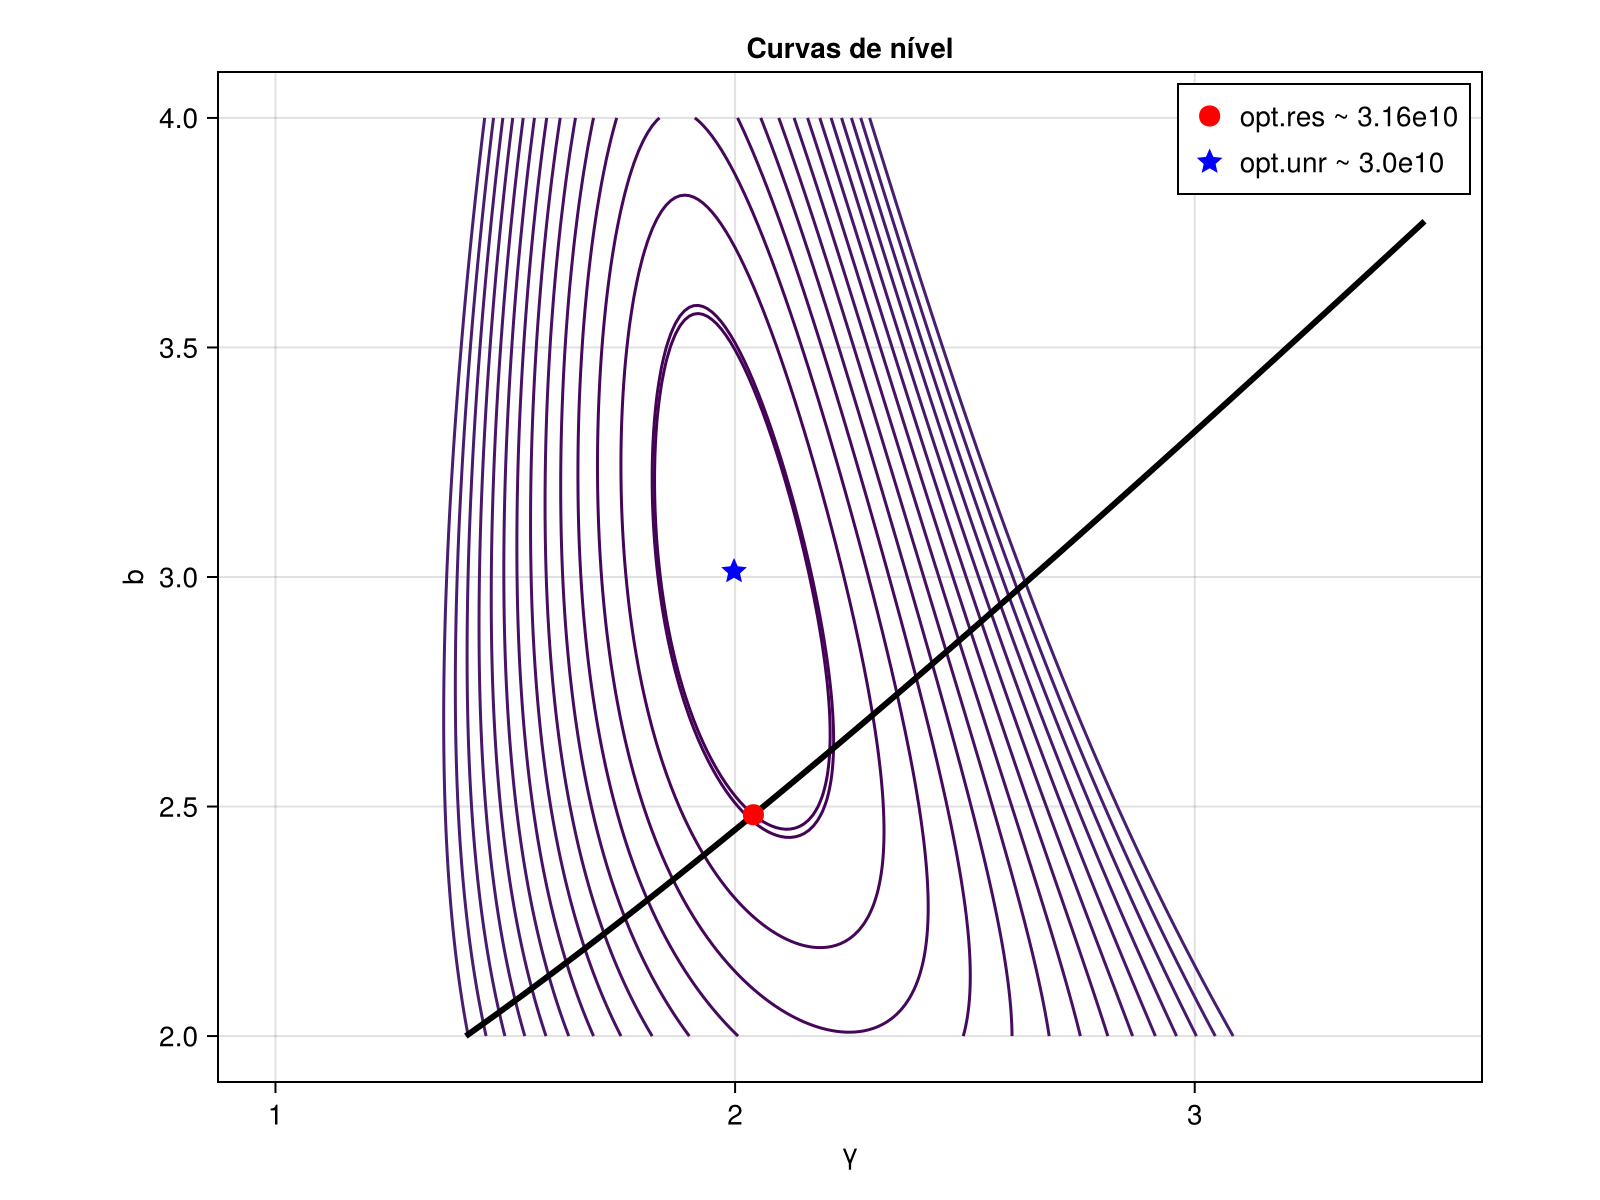

In [11]:
x1_range = 1:0.01:3.5
x2_range = 2:0.01:4

# matrizes de valores (Makie espera formato [i,j])
Z_Q = [ Q([x,y]) for x in x1_range, y in x2_range ]
Z_G = [ G([x,y]) for x in x1_range, y in x2_range ]   # se G(x) escalar

fig = Figure(resolution = (800, 600))
ax  = Axis(fig[1,1], xlabel="γ", ylabel="b", title="Curvas de nível",
           aspect=DataAspect())

# curvas de nível de Q(x)
contour!(ax, x1_range, x2_range, Z_Q;
         colormap = :viridis,
         levels = sort!(  [ LinRange(Q(opt_unr), median(Z_Q), 15) ; Q(opt_res) ]   ) ,
         linewidth = 1.5)

# curva de nível G(x)=0
contour!(ax, x1_range, x2_range, Z_G; levels=[0.0], color=:black, linewidth=3)

# pontos
scatter!(ax, [opt_res[1]], [opt_res[2]];
         color=:red,  marker=:circle, markersize=15, label="opt.res ~ $( round( Q(opt_res),  sigdigits=3) )")

scatter!(ax, [opt_unr[1]], [opt_unr[2]];
         color=:blue, marker=:star5,  markersize=15, label="opt.unr ~ $( round( Q(opt_unr),  sigdigits=3) )")

axislegend(ax)

fig
